
## Data set: Multiomics_data for prediction gestational_age


## Written By Khatoon Khedri

## Gestational age

Gestational age is a method of studying the patterns of fetal growth and development over time based on gestational age at birth. Gestational age is the number of weeks that have passed since the first day of the last menstrual period. It is an important indicator of fetal maturity and health outcomes.

First, I did two analyses on the features, such as the number of observations and the number of Principle Components (PCs) needed to capture 90% variance. Next, based on the task, I trained "immune_system". Moreover, I have trained the another modality "plasma_somalogic".I have trained these modalities through following steps:
	
>1. Cleaning dataset

>2. Scaling  the dataset

>3. Feature selection: The method using this paper was a  bootstrapping procedure used to reduce the number of features used in each model. One hundred bootstrap iterations were performed on each dataset where 57 samples were drawn randomly and with replacement. Piece-wise regression between the number of features (calculated by applying a range of thresholds to the mean coefficient of each measurement across all bootstrap iterations). Unfortunately, I could not find Piece-wise regression method for feature selection. I have used RidgeCV(). This method is much more efficient that other methods like SFS.

>4. Cross-validation: All algorithms were evaluated using the same two-layer leave-one-patient-out CV strategy. In Elastic Net, I have used Fig. S1. to choose the best parameters.

>5. Training and evaluation: For the evalotion, I have used the method pearsonr. To compiar and visulize result, I have considerd -log(10, a). 



In [27]:
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample # for Bootstrap sampling
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.linear_model import RidgeCV


In [28]:
# code for loading the data


with open("task1_multiomics_data.pickle", "rb") as file:
    data_multiomics = pickle.load(file)
    

data_multiomics.head()

Training/Validation Gates ID       MRN Study Subject ID Number     Sex  \
                                                                           
0                   T  PTLG002  16661779                   10565    Male   
1                   T  PTLG002  16661779                   10565    Male   
2                   T  PTLG002  16661779                   10565    Male   
3                   T  PTLG002  16661779                   10565    Male   
4                   T  PTLG004  23587868                   10603  Female   

  sex_bin timepoint gestational_age cellfree_rna                ...  \
                                       0_C2orf76      1_ACTL10  ...   
0       1         1              11     0.312437 -1.892930e-16  ...   
1       1         2              18     0.312437 -1.892930e-16  ...   
2       1         3              32     0.312437 -1.892930e-16  ...   
3       1         4              45     0.312437 -1.892930e-16  ...   
4       0         1              11     5.204209  1.734736e+00  ...   

  plasma_somalogic                                                             \
       1290_UBE2G2 1291_TAGLN2 1292_ATP5O 1293_POMC 1294_CRYZL1 1295_SERPINF1   
0           4804.4      2233.0     3610.9     715.8       151.4       37885.8   
1           4086.0      2160.5     2260.4     825.2       161.0       41821.5   
2           4328.0      1818.4     2445.2    1241.8       194.6       45526.1   
3           3442.4      2661.4     3879.2     703.6       153.7       36862.5   
4           4261.9      1804.6     1470.6     526.8       163.0       38938.3   

                                              
  1296_CTSF 1297_FTCD 1298_USP25 1299_PLXNB2  
0    1479.1    3261.8      561.3      3227.0  
1    1465.1    1839.8      597.8      3366.0  
2    1428.3    3057.2      625.7      8703.7  
3    1063.6    7339.7      593.2      2918.9  
4    1170.1    1036.8      552.8      3457.1  

[5 rows x 61274 columns]

## Data Analysis

In [7]:
# Creating the list of number of mearsurement in log 10 scale
Features=["cellfree_rna", "plasma_luminex", "serum_luminex", "microbiome",
          "immune_system", "metabolomics", "plasma_somalogic"]

num_measure=[]
multi_pca=[]

for i in range(7):
    Modularity=data_multiomics[Features[i]]
    x=math.log10(Modularity.shape[1])
    num_measure.append(x)
    
# creating the list of number of PCs for 90% variance

for j in range(7):
    Modularity=data_multiomics[Features[j]]
    Modularity_std = StandardScaler().fit_transform(Modularity)
    pca = PCA().fit(Modularity_std)
    for i in range(len(np.cumsum(pca.explained_variance_ratio_))):
            if np.cumsum(pca.explained_variance_ratio_)[i]>=0.95:
                multi_pca.append(i)
                break

for i in   range(len(Features)):
    print(f'Number of PCs for 90% variance for {Features[i]}: {multi_pca[i]}')

Number of PCs for 90% variance for cellfree_rna: 50
Number of PCs for 90% variance for plasma_luminex: 13
Number of PCs for 90% variance for serum_luminex: 12
Number of PCs for 90% variance for microbiome: 20
Number of PCs for 90% variance for immune_system: 30
Number of PCs for 90% variance for metabolomics: 27
Number of PCs for 90% variance for plasma_somalogic: 37


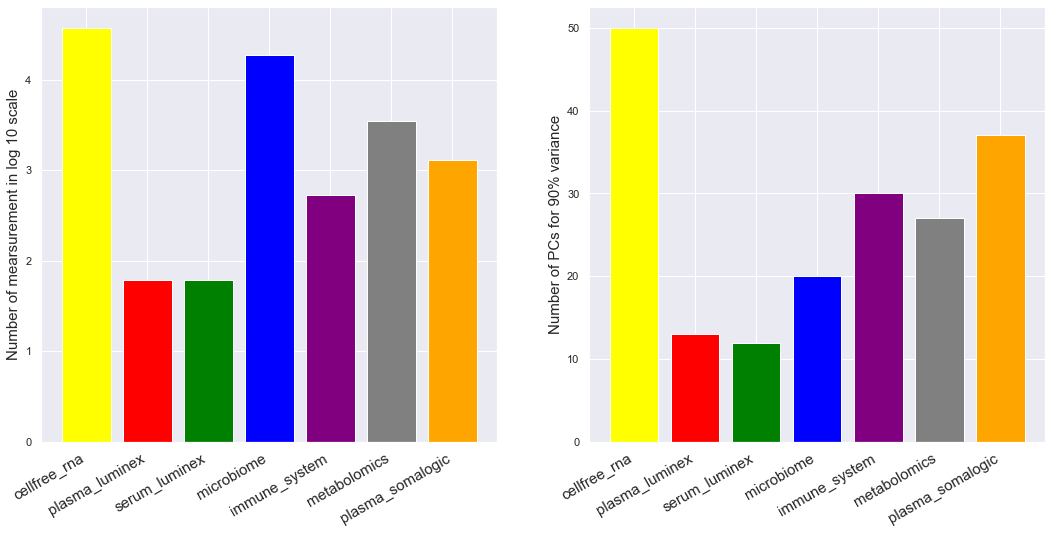

In [81]:
#plot 1: Number of mearsurement in log 10 scale

fig = plt.figure(figsize=(18, 8))

data = {'x':Features,  'Number':num_measure }
df = pd.DataFrame(data)

plt.subplot(1, 2, 1)
colors = ['yellow','red','green','blue','purple','gray', 'orange']
plt.bar(df['x'], df['Number'], color=colors)
plt.ylabel('Number of mearsurement in log 10 scale', fontsize=15)
plt.xticks(rotation=30, ha="right",fontsize=15)


#plot 2: Number of PCs for 90% variance
data = {'x':Features,  'Number':multi_pca }
df = pd.DataFrame(data)
plt.subplot(1, 2, 2)

colors = ['yellow','red','green','blue','purple','gray', 'orange']
plt.bar(df['x'], df['Number'], color=colors)
plt.ylabel('Number of PCs for 90% variance', fontsize=15)
plt.xticks(rotation=30, ha="right", fontsize=15)
plt.show()



   > (B) Data from each time point of each subject were analyzed using seven high-throughput assays, which produced different number of measurements.

   > (C) The seven datasets had a range of correlations among the measured features. The internal correlation between features from each dataset was quantified using the number of Principle Components (PCs) needed to capture 90% variance (datasets in which most features are highly correlated would need fewer principal components.



## plasma_somalogic

In [29]:
# load the dataset  
plasma_somalogic=data_multiomics["plasma_somalogic"]
y= data_multiomics["gestational_age"]

print(f'Shape of the dataset')
print(f'Number of Features: {plasma_somalogic.shape[1]}')
print(f'Number of Observations: {plasma_somalogic.shape[0]}')


Shape of the dataset
Number of Features: 1300
Number of Observations: 68


### Cleaning the data set

In [30]:
# Cleaning the data set
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
plasma_somalogic.columns = [regex.sub("_", col)
                         if any(x in str(col) for x in set(('[', ']', '<'))) 
                         else col for col in plasma_somalogic.columns.values]

### Scaling

In [31]:
# Import the StandardScaler class from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

# Create an instance of the StandardScaler class
scaler = StandardScaler()

# Fit the scaler to the dataframe and transform it
scaled_plasma_somalogic = scaler.fit_transform(plasma_somalogic)

# Convert the scaled array back to a dataframe
scaled_plasma_somalogic = pd.DataFrame(scaled_plasma_somalogic, columns=plasma_somalogic.columns)

### Feature Selection

In [32]:
from sklearn.utils import resample
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoLars

model = RidgeCV()

# Set the number of bootstrap iterations
n_iterations = 100
# Set the number of samples to draw in each iteration
n_samples = 57
# Initialize a list to store the coefficients of each feature
coef_list = []
# Loop through the iterations
for i in range(n_iterations):
    
     # Randomly sample the data with replacement
    X_sample, y_sample = resample(scaled_plasma_somalogic, y, n_samples=n_samples)   
    #reg = linear_model.LassoLars(alpha=0.1)
    #reg.fit(X_sample, y_sample)  
    model.fit(X_sample, y_sample)
    coef_list.append(model.coef_)
    #coef_list.append(reg.coef_)
    

In [34]:
#Calculate the mean coefficient for each feature across all iterations
mean_coef = np.mean(coef_list, axis=0)

# Initialize a list to store the number of features selected for each threshold
n_features_list = []

#for thresh in thresholds:
thresh=0.18
#thresh=0.35
# Select features with a coefficient greater than the threshold
idx_features = np.abs(mean_coef) > thresh
#print(idx_features)
selected_plasma_somalogic =scaled_plasma_somalogic.iloc[:, idx_features] 
selected_plasma_somalogic.head()

,97_ANXA5,133_IGFBP3,210_SIGLEC6,421_GNLY,477_NTN4,498_CD207,508_KLK7,518_REN,571_CXCL13,832_FCRL3,857_MMP12,885_SLITRK5,909_ITIH4,943_CGA CGB,1192_WNK3,1261_KLK3
0,-0.407928,0.701369,0.633652,1.693130,-0.712800,0.088074,1.173202,0.568688,3.490815,-1.718181,-0.020611,1.349207,-0.544227,0.659590,-0.359679,-0.590494
1,-0.917530,0.592598,-0.652648,0.322127,0.060908,-1.151252,-0.365976,-0.210812,4.106061,-1.261408,0.233717,0.933960,-0.031297,0.997559,-0.494721,-0.631257
2,-0.751097,0.716405,3.549171,-0.542939,2.467200,0.661263,2.566115,-0.691150,1.793027,-1.541997,-1.199266,-0.362902,-2.145647,0.865635,0.255386,-0.625882
3,-0.791866,-1.308527,-0.902257,-0.273198,-0.014000,-1.646983,0.446169,-1.591190,-1.005495,-2.227156,-1.293668,-1.537820,-1.329035,-1.821992,1.512753,-0.057878
4,0.408556,0.932128,1.441730,0.409541,-0.897504,0.909128,0.765878,1.360826,0.607364,-0.236933,1.432818,1.047980,-0.170842,0.246944,0.823925,-0.564512


In [35]:
from sklearn.model_selection import train_test_split

plasma_somalogic_train, plasma_somalogic_test, y_train_plasma_somalogic, y_test_plasma_somalogic = train_test_split(selected_plasma_somalogic ,
                                                                                                        y, test_size=0.2, random_state=42)


## Introduction in ElasticNet Model

>ElasticNet is a type of linear regression that combines the penalties of Lasso and Ridge regression methods. Lasso regression uses an L1 penalty, which shrinks some of the coefficients to zero and performs variable selection. Ridge regression uses an L2 penalty, which shrinks all of the coefficients and reduces multicollinearity. ElasticNet uses a weighted sum of both penalties, which allows it to balance the benefits and drawbacks of each method.

>ElasticNet has two parameters: alpha and l1_ratio. Alpha is the overall strength of the regularization, which controls how much the coefficients are shrunk. L1_ratio is the ratio of the L1 penalty to the total penalty, which controls how much variable selection is performed. For l1_ratio = 0, ElasticNet is equivalent to Ridge regression. For l1_ratio = 1, ElasticNet is equivalent to Lasso regression. For 0 < l1_ratio < 1, ElasticNet is a combination of Lasso and Ridge regression.

### Cross Validation

In [36]:
EN= ElasticNet()
loo = LeaveOneOut()
alpha_range =[0.001,0.01,0.1,0.2,0.3,0.4,.5,0.6,0.7,0.8, 0.9]
max_iter = [100]
l1_ratio = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tol = [0.5]

grid = GridSearchCV(EN, param_grid={'alpha': alpha_range,
                                            'max_iter': max_iter,
                                            'l1_ratio': l1_ratio,
                                            'tol':tol},   
                                scoring='neg_mean_squared_error', cv=loo)
grid.fit(selected_plasma_somalogic , y )
print( "The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'alpha': 0.6, 'l1_ratio': 0.4, 'max_iter': 100, 'tol': 0.5} with a score of -35.02


### Training

In [37]:
# Train the final model on the selected features
EN_par= ElasticNet(alpha = 0.6, 
                        max_iter = 100,
                        l1_ratio = 0.4,
                        tol = 0.5)

EN_par.fit(plasma_somalogic_train, y_train_plasma_somalogic)
pred_train_EN_par_plasma_somalogic = EN_par.predict(plasma_somalogic_train)
pred_test_EN_par_plasma_somalogic = EN_par.predict(plasma_somalogic_test)

# calculate Pearson's correlation
corr_train_EN_par_plasma_somalogic = pearsonr(y_train_plasma_somalogic, pred_train_EN_par_plasma_somalogic)[0]
corr_train_EN_par_plasma_somalogic_log10=-math.log(10,corr_train_EN_par_plasma_somalogic )
print('Pearsons correlation on train set: %.9f' % corr_train_EN_par_plasma_somalogic)
print('Pearsons correlation on train set in log10: %.3f' % corr_train_EN_par_plasma_somalogic_log10)

corr_test_EN_par_plasma_somalogic = pearsonr(y_test_plasma_somalogic, pred_test_EN_par_plasma_somalogic)[0]
corr_test_EN_par_plasma_somalogic_log10=-math.log(10,corr_test_EN_par_plasma_somalogic)
print('Pearsons correlation on test set: %.9f' % corr_test_EN_par_plasma_somalogic)
print('Pearsons correlation on test set in log10: %.3f' % corr_test_EN_par_plasma_somalogic_log10)

Pearsons correlation on train set: 0.931495854
Pearsons correlation on train set in log10: 32.447
Pearsons correlation on test set: 0.823184541
Pearsons correlation on test set in log10: 11.834


## Support Vector Regression

>Support vector regression (SVR) is a type of machine learning model that can perform regression tasks by finding a hyperplane that fits the data with the minimum error within a certain tolerance. SVR can handle linear and nonlinear regression problems by using different kernels, such as linear, polynomial, radial basis function (RBF), or sigmoid.

>SVR has three main parameters: C, epsilon, and kernel. Here is a brief explanation of each parameter and how it affects the model:

>•  C is the regularization parameter that controls the trade-off between fitting the data and avoiding overfitting. A higher C means less regularization and more complexity. A lower C means more regularization and less complexity. The optimal C depends on the scale and noise of the data and the desired balance between bias and variance.

>•  Epsilon is the tolerance parameter that defines the width of the epsilon-tube within which no penalty is associated with the prediction error. A higher epsilon means less sensitivity to errors and more smoothness. A lower epsilon means more sensitivity to errors and more accuracy. The optimal epsilon depends on the scale and noise of the data and the desired balance between precision and robustness.

>•  Kernel is the function that transforms the data into a higher-dimensional space where a linear hyperplane can fit the data better. Different kernels can handle different types of nonlinearities in the data. The most common kernels are linear, polynomial, RBF, and sigmoid. The optimal kernel depends on the shape and structure of the data and the desired flexibility and interpretability of the model.

In [41]:
from sklearn.svm import SVR

# Define the parameter grid
parameter_grid = {'C': [ 10, 20, 30, 35, 40],'epsilon': [ 0.001, 0.01, 0.1, 0.5]}

# Create an SVR object
svr = SVR(kernel='rbf')

# Create a GridSearchCV object
grid_search = GridSearchCV(svr, parameter_grid,scoring="neg_mean_squared_error", cv=loo)

# Fit the grid search on the training data
grid_search.fit(selected_plasma_somalogic, y)

# Print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'C': 20, 'epsilon': 0.001}
Best score: -32.8023053399028


In [42]:
from sklearn.svm import SVR


            
svr= SVR( C=20, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma='auto',
            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(plasma_somalogic_train, y_train_plasma_somalogic)
pred_train_svr_plasma_somalogic = svr.predict(plasma_somalogic_train)
pred_test_svr_plasma_somalogic = svr.predict(plasma_somalogic_test)
# calculate Pearson's correlation

corr_train_svr_plasma_somalogic= pearsonr(y_train_plasma_somalogic, pred_train_svr_plasma_somalogic)[0]
corr_train_svr_plasma_somalogic_log10=-math.log(10,corr_train_svr_plasma_somalogic )
print('Pearsons correlation on train set: %.9f' % corr_train_svr_plasma_somalogic)
print('Pearsons correlation on train set in log10: %.3f' % corr_train_svr_plasma_somalogic_log10)


corr_test_svr_plasma_somalogic = pearsonr(y_test_plasma_somalogic, pred_test_svr_plasma_somalogic)[0]
corr_test_svr_plasma_somalogic_log10=-math.log(10,corr_test_svr_plasma_somalogic)
print('Pearsons correlation on test set: %.9f' % corr_test_svr_plasma_somalogic)
print('Pearsons correlation on test set in log10: %.3f' % corr_test_svr_plasma_somalogic_log10)

Pearsons correlation on train set: 0.996146893
Pearsons correlation on train set in log10: 596.440
Pearsons correlation on test set: 0.553525325
Pearsons correlation on test set in log10: 3.893


## Immune_system

In [43]:
# code for loading the data
with open("task1_multiomics_data.pickle", "rb") as file:
    data_multiomics = pickle.load(file)
    
immune_system=data_multiomics["immune_system"]
y= data_multiomics["gestational_age"]

print(f'Shape of the dataset')
print(f'Number of Features: {immune_system.shape[1]}')
print(f'Number of Observations: {immune_system.shape[0]}')

Shape of the dataset
Number of Features: 534
Number of Observations: 68


In [44]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
immune_system.columns = [regex.sub("_", col)
                         if any(x in str(col) for x in set(('[', ']', '<'))) 
                         else col for col in immune_system.columns.values]

In [45]:
# Import the StandardScaler class from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

# Create an instance of the StandardScaler class
scaler = StandardScaler()

# Fit the scaler to the dataframe and transform it
scaled_immune_system = scaler.fit_transform(immune_system)

# Convert the scaled array back to a dataframe
scaled_immune_system = pd.DataFrame(scaled_immune_system, columns=immune_system.columns)

## Feature Selection

In [46]:
#  method 2

from sklearn.utils import resample
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoLars



# Set the number of bootstrap iterations
n_iterations = 100
# Set the number of samples to draw in each iteration
n_samples = 57
# Initialize a list to store the coefficients of each feature
coef_list = []
# Loop through the iterations
for i in range(n_iterations):
    
     # Randomly sample the data with replacement
    X_sample, y_sample = resample(scaled_immune_system, y, n_samples=n_samples)   
    reg = linear_model.LassoLars(alpha=0.1)
    reg.fit(X_sample, y_sample)
    coef_list.append(reg.coef_)
    #model = RidgeCV()
    #model.fit(X_sample, y_sample)
    #coef_list.append(model.coef_)
    

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [48]:
#Calculate the mean coefficient for each feature across all iterations
mean_coef = np.mean(coef_list, axis=0)

# Initialize a list to store the number of features selected for each threshold
n_features_list = []

#for thresh in thresholds:
thresh=0.25
#thresh=0.35
# Select features with a coefficient greater than the threshold
idx_features = np.abs(mean_coef) > thresh
#print(idx_features)
selected_immune_system =scaled_immune_system.iloc[:, idx_features] 
selected_immune_system  


,0_Bcells,13_Gr,84_CD8+Tcells_mem_STAT5_IFNa100,88_Gr_STAT5_IFNa100,100_Bcells_ERK_IL100,101_CD16+CD56-NKcells_ERK_IL100,109_CD8+Tcells_mem_ERK_IL100,124_Tregs_ERK_IL100,138_Gr_STAT1_IL100,175_Bcells_STAT5_IL100,...,226_CD45RA-Tregs_IkB_LPS100,235_Tregs_IkB_LPS100,257_mDCs_NFkB_LPS100,275_CD56+CD16-NKcells_S6_LPS100,276_CD7+NKcells_S6_LPS100,277_cMCs_S6_LPS100,280_M-MDSC_S6_LPS100,344_CD8+Tcells_naive_IkB_Unstim,441_CD56+CD16-NKcells_S6_Unstim,472_Gr_STAT1_Unstim
0,-1.094280,0.553031,1.398760,0.134607,0.570807,-0.982630,-0.829004,-0.815784,0.042662,1.196679,...,1.978585,2.141188,-0.661526,-1.318893,-2.203629,-0.235271,-0.533909,-0.812315,0.416432,0.645707
1,-1.103726,0.184777,0.012009,0.543638,0.651584,-0.721445,-0.505618,-1.898608,0.319293,1.282149,...,1.301053,1.594633,0.712964,-0.452110,0.947072,1.185155,0.858527,-1.104664,-0.061579,0.704721
2,-1.093097,0.648528,0.189194,0.592576,0.858316,-1.608866,-1.259767,-0.434355,0.601213,2.750683,...,-0.001130,0.372828,0.660996,-1.153754,-1.046109,-0.275561,-0.261392,0.751124,0.123564,0.917946
3,-1.194700,-1.447863,-0.462358,-1.633009,1.552760,-1.309729,-0.809038,0.176524,-0.964074,3.363093,...,0.621100,0.862511,-0.138322,0.355261,-0.198898,1.786703,1.589618,-0.530835,-0.083060,-0.447029
4,0.443964,0.687266,-0.297260,-0.249786,0.084590,2.996392,1.478460,-1.612645,0.762050,-1.493475,...,0.620327,0.620788,3.541264,-1.391488,-1.449777,2.439006,2.614147,1.023534,2.139893,0.302811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.075726,0.196874,-0.155620,-0.197770,0.839942,-0.254631,0.210147,-0.192816,-0.898782,1.566811,...,0.153837,0.637421,1.435354,1.208161,-0.211281,1.689016,1.575076,-0.788131,-0.626244,-0.537050
64,-0.560942,0.458630,0.244529,0.053073,0.015081,-0.080550,-0.079419,0.033385,-0.155668,0.427103,...,0.079933,0.142877,0.202914,-0.040215,0.205883,-0.071167,0.003577,-0.925289,0.106889,1.572501
65,-0.844940,0.721296,-0.070805,0.217538,-0.088183,0.006552,-0.143044,0.113686,-0.240536,0.213982,...,0.107572,0.057454,-0.018315,-0.009286,0.317755,-0.299585,-0.313516,-0.013728,0.022386,-0.291669
66,-1.115384,0.649813,0.112432,0.355288,-0.071515,-0.090474,-0.071542,0.092454,-0.130250,0.430753,...,0.129067,0.171948,-0.032010,0.055997,0.250233,-0.245698,-0.232083,0.068054,-0.226838,-0.252070


In [49]:
from sklearn.model_selection import train_test_split

immune_system_train, immune_system_test, y_train_immune_system, y_test_immune_system = train_test_split(selected_immune_system ,
                                                                                                        y, test_size=0.2, random_state=42)


In [50]:
loo = LeaveOneOut()
alpha_range =[0.001,0.01,0.1,0.2,0.3,0.4,.5,0.6,0.7,0.8, 0.9]
max_iter = [100]
l1_ratio = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tol = [0.5]

grid = GridSearchCV(EN, param_grid={'alpha': alpha_range,
                                            'max_iter': max_iter,
                                            'l1_ratio': l1_ratio,
                                            'tol':tol},   
                                scoring='neg_mean_squared_error', cv=loo)
grid.fit(selected_immune_system , y )
print( "The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'alpha': 0.3, 'l1_ratio': 0.1, 'max_iter': 100, 'tol': 0.5} with a score of -47.54


In [51]:
# Train the final model on the selected features
EN_par= ElasticNet(alpha = 0.3, 
                        max_iter = 100,
                        l1_ratio = 0.1,
                        tol = 0.5)

EN_par.fit(immune_system_train, y_train_immune_system)
pred_train_EN_par_immune_system = EN_par.predict(immune_system_train)
pred_test_EN_par_immune_system = EN_par.predict(immune_system_test)

# calculate Pearson's correlation
corr_train_EN_par_immune_system, _ = pearsonr(y_train_immune_system, pred_train_EN_par_immune_system)
corr_train_EN_par_immune_system_log10=-math.log(10,corr_train_EN_par_immune_system )
print('Pearsons correlation on train set: %.3f' % corr_train_EN_par_immune_system)
print('Pearsons correlation on train set in log10: %.3f' % corr_train_EN_par_immune_system_log10)

corr_test_EN_par_immune_system, _ = pearsonr(y_test_immune_system, pred_test_EN_par_immune_system)
corr_test_EN_par_immune_system_log10=-math.log(10,corr_test_EN_par_immune_system)
print('Pearsons correlation on test set: %.3f' % corr_test_EN_par_immune_system)
print('Pearsons correlation on test set in log10: %.3f' % corr_test_EN_par_immune_system_log10)

Pearsons correlation on train set: 0.915
Pearsons correlation on train set in log10: 25.888
Pearsons correlation on test set: 0.773
Pearsons correlation on test set in log10: 8.928


## Support Vector Regression

In [52]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

# Define the parameter grid
parameter_grid = {'C': [ 10, 20, 30, 35, 40],'epsilon': [ 0.001, 0.01, 0.1, 0.5]}

# Create an SVR object
svr = SVR(kernel='rbf')

# Create a GridSearchCV object
grid_search = GridSearchCV(svr, parameter_grid,scoring="neg_mean_squared_error", cv=loo)

# Fit the grid search on the training data
grid_search.fit(selected_immune_system, y)

# Print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'C': 20, 'epsilon': 0.5}
Best score: -60.852545182952646


In [53]:

from sklearn.svm import SVR

            
svr= SVR( C=20, cache_size=200, coef0=0.0, degree=3, epsilon=0.5, gamma='auto',
            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(immune_system_train, y_train_immune_system)
pred_train_svr_immune_system = svr.predict(immune_system_train)
pred_test_svr_immune_system = svr.predict(immune_system_test)
# calculate Pearson's correlation

corr_train_svr_immune_system= pearsonr(y_train_immune_system, pred_train_svr_immune_system)[0]
corr_train_svr_immune_system_log10=-math.log(10,corr_train_svr_immune_system )
print('Pearsons correlation on train set: %.9f' % corr_train_svr_immune_system)
print('Pearsons correlation on train set in log10: %.3f' % corr_train_svr_immune_system_log10)


corr_test_svr_immune_system = pearsonr(y_test_immune_system, pred_test_svr_immune_system)[0]
corr_test_svr_immune_system_log10=-math.log(10,corr_test_svr_immune_system)
print('Pearsons correlation on test set: %.9f' % corr_test_svr_immune_system)
print('Pearsons correlation on test set in log10: %.3f' % corr_test_svr_immune_system_log10)

Pearsons correlation on train set: 0.980539757
Pearsons correlation on train set in log10: 117.167
Pearsons correlation on test set: 0.736802950
Pearsons correlation on test set in log10: 7.539


# metabolomics

In [8]:
# load the dataset  
metabolomics=data_multiomics["metabolomics"]
y= data_multiomics["gestational_age"]

print(f'Shape of the dataset')
print(f'Number of Features: {metabolomics.shape[1]}')
print(f'Number of Observations: {metabolomics.shape[0]}')

Shape of the dataset
Number of Features: 3485
Number of Observations: 68


### Cleaning the data set

In [9]:
# Cleaning the data set
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
metabolomics.columns = [regex.sub("_", col)
                         if any(x in str(col) for x in set(('[', ']', '<'))) 
                         else col for col in metabolomics.columns.values]

### Scaling

In [10]:
# Import the StandardScaler class from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

# Create an instance of the StandardScaler class
scaler = StandardScaler()

# Fit the scaler to the dataframe and transform it
scaled_metabolomics = scaler.fit_transform(metabolomics)

# Convert the scaled array back to a dataframe
scaled_metabolomics = pd.DataFrame(scaled_metabolomics, columns=metabolomics.columns)

### Feature Selection

In [14]:
from sklearn.utils import resample
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoLars

model = RidgeCV()

# Set the number of bootstrap iterations
n_iterations = 100
# Set the number of samples to draw in each iteration
n_samples = 57
# Initialize a list to store the coefficients of each feature
coef_list = []
# Loop through the iterations
for i in range(n_iterations):
    
     # Randomly sample the data with replacement
    X_sample, y_sample = resample(scaled_metabolomics, y, n_samples=n_samples)   
    reg = linear_model.LassoLars(alpha=0.1)
    reg.fit(X_sample, y_sample)  
    #model.fit(X_sample, y_sample)
    #coef_list.append(model.coef_)
    coef_list.append(reg.coef_)
    

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale

In [15]:
#Calculate the mean coefficient for each feature across all iterations
mean_coef = np.mean(coef_list, axis=0)

# Initialize a list to store the number of features selected for each threshold
n_features_list = []

#for thresh in thresholds:
thresh=0.18
#thresh=0.35
# Select features with a coefficient greater than the threshold
idx_features = np.abs(mean_coef) > thresh
#print(idx_features)
selected_metabolomics =scaled_metabolomics.iloc[:, idx_features] 
selected_metabolomics.head()

,165,168,348,380,413,421,495,545,612,669,...,1349,1455,1470,1543,1632,1724,2393,2548,2838,3377
0,-0.178129,0.032303,-0.185955,-0.364824,-0.374969,-1.066678,-0.514228,0.477152,-0.198339,-0.165594,...,0.174088,-0.879900,-1.209209,-2.198623,0.404630,1.263188,0.295037,-0.740396,-0.197602,0.281869
1,-0.181891,-0.126255,0.719688,-0.275543,-0.636322,-0.925513,-0.377820,1.265607,-0.358229,-0.488721,...,0.062703,-0.648304,-0.911871,-1.976387,0.184462,-0.025618,0.081488,-0.336269,-0.379620,-0.419485
2,-0.184717,-0.130642,-0.772642,-0.421765,-0.626563,-0.258113,-0.322585,-0.245721,-0.512353,0.027349,...,-0.500472,1.243699,1.301918,-0.191038,-0.049519,-0.106782,-0.105430,-0.512841,0.558920,0.105221
3,-0.183104,-0.133782,1.559172,0.972513,0.554663,0.573007,1.295970,0.640271,1.143056,1.128579,...,-0.884540,-1.181669,-0.789149,0.445447,0.441801,-0.846044,-1.497858,1.091449,-0.477933,-0.551289
4,-0.180988,-0.127615,-0.676221,-0.600591,1.014513,-0.094995,0.613258,0.705778,0.839523,0.257262,...,0.492856,-0.510026,-0.731939,-1.767199,0.036409,2.146291,0.786356,-0.829356,-0.465191,-0.488096


In [16]:
from sklearn.model_selection import train_test_split

metabolomics_train, metabolomics_test, y_train_metabolomics, y_test_metabolomics = train_test_split(selected_metabolomics ,
                                                                                                        y, test_size=0.2, random_state=42)


### Cross Validation

In [19]:
EN= ElasticNet()
loo = LeaveOneOut()
alpha_range =[0.001,0.01,0.1,0.2,0.3,0.4,.5,0.6,0.7,0.8, 0.9]
max_iter = [100]
l1_ratio = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tol = [0.5]

grid = GridSearchCV(EN, param_grid={'alpha': alpha_range,
                                            'max_iter': max_iter,
                                            'l1_ratio': l1_ratio,
                                            'tol':tol},   
                                scoring='neg_mean_squared_error', cv=loo)
grid.fit(selected_metabolomics , y )
print( "The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'alpha': 0.9, 'l1_ratio': 0.1, 'max_iter': 100, 'tol': 0.5} with a score of -24.71


### Training

In [22]:
# Train the final model on the selected features
EN_par= ElasticNet(alpha = 0.6, 
                        max_iter = 100,
                        l1_ratio = 0.4,
                        tol = 0.5)

EN_par.fit(metabolomics_train, y_train_metabolomics)
pred_train_EN_par_metabolomics = EN_par.predict(metabolomics_train)
pred_test_EN_par_metabolomics = EN_par.predict(metabolomics_test)

# calculate Pearson's correlation
corr_train_EN_par_metabolomics = pearsonr(y_train_metabolomics, pred_train_EN_par_metabolomics)[0]
corr_train_EN_par_metabolomics_log10=-math.log(10,corr_train_EN_par_metabolomics )
print('Pearsons correlation on train set: %.9f' % corr_train_EN_par_metabolomics)
print('Pearsons correlation on train set in log10: %.3f' % corr_train_EN_par_metabolomics_log10)

corr_test_EN_par_metabolomics = pearsonr(y_test_metabolomics, pred_test_EN_par_metabolomics)[0]
corr_test_EN_par_metabolomics_log10=-math.log(10,corr_test_EN_par_metabolomics)
print('Pearsons correlation on test set: %.9f' % corr_test_EN_par_metabolomics)
print('Pearsons correlation on test set in log10: %.3f' % corr_test_EN_par_metabolomics_log10)

Pearsons correlation on train set: 0.948732553
Pearsons correlation on train set in log10: 43.752
Pearsons correlation on test set: 0.917938444
Pearsons correlation on test set in log10: 26.892


## Support Vector Regression

In [23]:
from sklearn.svm import SVR

# Define the parameter grid
parameter_grid = {'C': [ 10, 20, 30, 35, 40],'epsilon': [ 0.001, 0.01, 0.1, 0.5]}

# Create an SVR object
svr = SVR(kernel='rbf')

# Create a GridSearchCV object
grid_search = GridSearchCV(svr, parameter_grid,scoring="neg_mean_squared_error", cv=loo)

# Fit the grid search on the training data
grid_search.fit(selected_metabolomics, y)

# Print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'C': 20, 'epsilon': 0.001}
Best score: -28.849501345432216


In [25]:
from sklearn.svm import SVR


            
svr= SVR( C=20, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma='auto',
            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(metabolomics_train, y_train_metabolomics)
pred_train_svr_metabolomics = svr.predict(metabolomics_train)
pred_test_svr_metabolomics = svr.predict(metabolomics_test)
# calculate Pearson's correlation

corr_train_svr_metabolomics= pearsonr(y_train_metabolomics, pred_train_svr_metabolomics)[0]
corr_train_svr_metabolomics_log10=-math.log(10,corr_train_svr_metabolomics )
print('Pearsons correlation on train set: %.9f' % corr_train_svr_metabolomics)
print('Pearsons correlation on train set in log10: %.3f' % corr_train_svr_metabolomics_log10)


corr_test_svr_metabolomics = pearsonr(y_test_metabolomics, pred_test_svr_metabolomics)[0]
corr_test_svr_metabolomics_log10=-math.log(10,corr_test_svr_metabolomics)
print('Pearsons correlation on test set: %.9f' % corr_test_svr_metabolomics)
print('Pearsons correlation on test set in log10: %.3f' % corr_test_svr_metabolomics_log10)

Pearsons correlation on train set: 0.995930399
Pearsons correlation on train set in log10: 564.649
Pearsons correlation on test set: 0.917478113
Pearsons correlation on test set in log10: 26.735


### Evaluation models by plot   mean_squared_log_error

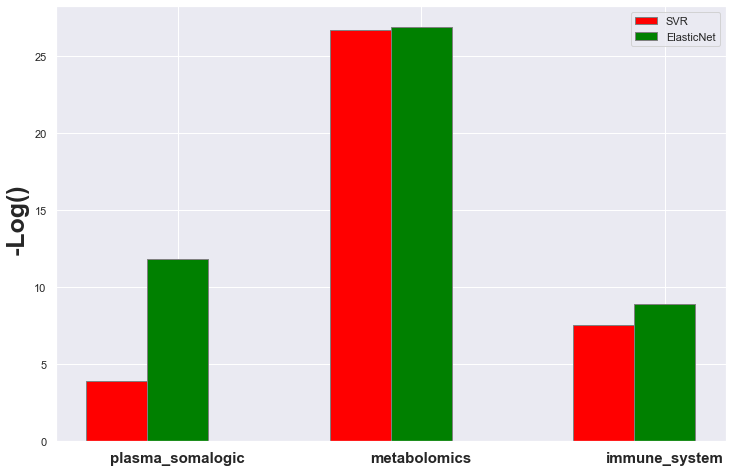

In [57]:

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
SVR = [corr_test_svr_plasma_somalogic_log10,corr_test_svr_metabolomics_log10, corr_test_svr_immune_system_log10]
ElasticNet = [corr_test_EN_par_plasma_somalogic_log10,corr_test_EN_par_metabolomics_log10, corr_test_EN_par_immune_system_log10]
 
 
# Set position of bar on X axis
br1 = np.arange(len(SVR ))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

 
# Make the plot
plt.bar(br1, SVR, color ='red', width = barWidth,
        edgecolor ='grey', label ='SVR')
plt.bar(br2, ElasticNet, color ='green', width = barWidth,
        edgecolor ='grey', label ='ElasticNet')

# Adding Xticks

plt.ylabel(' -Log()', fontweight ='bold', fontsize =25)
plt.xticks([r + barWidth for r in range(len(SVR))],
        ['plasma_somalogic','metabolomics', 'immune_system'], fontweight ='bold', fontsize =15)
 
plt.legend()
plt.show()

## Trajectory analysis 


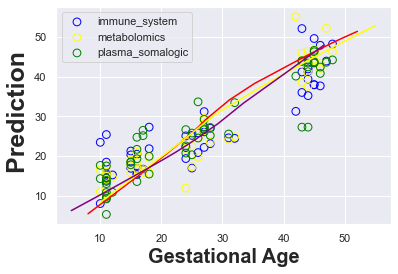

In [62]:
# Import the necessary modules
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

y_trn_immune_system=np.array(list(y_train_immune_system.iloc))
pred_immune_system=np.array(list(pred_train_EN_par_immune_system))

y_trn_metabolomics=np.array(list(y_train_metabolomics.iloc))
pred_metabolomics=np.array(list(pred_train_EN_par_metabolomics))

y_trn_plasma_somalogic=np.array(list(y_train_plasma_somalogic.iloc))
pred_plasma_somalogic=np.array(list(pred_train_EN_par_plasma_somalogic))



# Perform local regression
lowess_immune_system = sm.nonparametric.lowess(y_trn_immune_system, pred_immune_system, frac=0.8)
lowess_metabolomics = sm.nonparametric.lowess(y_trn_metabolomics, pred_metabolomics, frac=0.8)
lowess_plasma_somalogic = sm.nonparametric.lowess(y_trn_plasma_somalogic, pred_plasma_somalogic, frac=0.8)



# Plot the original data and the smoothed curve
figsize =(20, 20)
plt.scatter(y_train_immune_system,pred_immune_system, s=60, facecolors='none', edgecolors='blue')
plt.scatter(y_train_metabolomics,pred_metabolomics, s=60, facecolors='none', edgecolors='yellow')
plt.scatter(y_train_plasma_somalogic, pred_plasma_somalogic, s=60, facecolors='none', edgecolors='green')
                                              
plt.plot(lowess_immune_system[:, 0], lowess_immune_system[:, 1], color='red')
plt.plot(lowess_metabolomics[:, 0], lowess_metabolomics[:, 1], color='yellow')
plt.plot(lowess_plasma_somalogic[:, 0], lowess_plasma_somalogic[:, 1], color='purple')


plt.ylabel(' Prediction', fontweight ='bold', fontsize =25)
plt.xlabel('Gestational Age',  fontweight ='bold', fontsize =20)
plt.legend(['immune_system','metabolomics', 'plasma_somalogic'], loc='upper left')
plt.show()
